# Correlation Exploration

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.linalg import svd

In [203]:
sentimentsUS = pd.read_csv("../../data/sentimentsUS.csv")
covidUS = pd.read_csv("../../data/covidDataUS.csv")

sentimentsAU = pd.read_csv("../../data/sentimentsAU.csv")
sentimentsGB = pd.read_csv("../../data/sentimentsGB.csv")

covid = pd.read_csv("../../data/owid-covid-data.csv")

In [204]:
covid.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

Select columns which best represent the pandemic:

In [205]:
covid = covid[['iso_code',
               'date', 'new_cases', 'new_cases_smoothed',
               'new_deaths','new_deaths_smoothed', 
               'icu_patients', 'hosp_patients',
               'new_tests', 'new_tests_smoothed', 
               'new_vaccinations', 'new_vaccinations_smoothed']]

There are some columns in the sentiment columns which have weird values:

In [206]:
sum(sentimentsUS.timestamp == sentimentsUS.date)  # Are these columns necessary? They have the same (unexplained) values

688

In [207]:
sentimentsUS.drop(["timestamp", "date", "lang", "text", "day.1", "text_modified", "sentiment"], inplace=True, axis=1)
sentimentsAU.drop(["timestamp", "date", "lang", "text", "day.1", "text_modified", "sentiment"], inplace=True, axis=1)
sentimentsGB.drop(["timestamp", "date", "lang", "text", "day.1", "text_modified", "sentiment"], inplace=True, axis=1)

Complete NA values in sentiment analysis and covid data with values 0


In [208]:
sentimentsUS.fillna(0, inplace=True)
sentimentsAU.fillna(0, inplace=True)
sentimentsGB.fillna(0, inplace=True)

Obtain COVID data for each of the three countries analyzed:

In [209]:
covidUS = covid[covid.iso_code == "USA"]
covidAU = covid[covid.iso_code == "AUS"]
covidGB = covid[covid.iso_code == "GBR"]

Define which country will be used

In [210]:
#sentiments = sentimentsUS
#covid = covidUS
#iso_code = "USA"

sentiments = sentimentsAU
covid = covidAU
iso_code = "AUS"

#sentiments = sentimentsGB
#covid = covidGB
#iso_code = "GBR"

### 1. Join datasets on date

Get data where we have info on covid cases and sentiment analysis


In [211]:
cov_sent = pd.merge(covid, sentiments, how="inner", left_on="date", right_on="day")
cov_sent.drop("day", axis=1, inplace=True)
cov_sent.drop("iso_code", axis=1, inplace=True)


cov_sent.fillna(0, inplace=True)
cov_sent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 0 to 667
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date                       668 non-null    object 
 1   new_cases                  668 non-null    float64
 2   new_cases_smoothed         668 non-null    float64
 3   new_deaths                 668 non-null    float64
 4   new_deaths_smoothed        668 non-null    float64
 5   icu_patients               668 non-null    float64
 6   hosp_patients              668 non-null    float64
 7   new_tests                  668 non-null    float64
 8   new_tests_smoothed         668 non-null    float64
 9   new_vaccinations           668 non-null    float64
 10  new_vaccinations_smoothed  668 non-null    float64
 11  negPercentage              668 non-null    float64
 12  netPercentage              668 non-null    float64
 13  posPercentage              668 non-null    float64

Normalize data

In [212]:
cov_sent_norm = (cov_sent.drop("date",axis=1) - cov_sent.drop("date",axis=1).mean()) / cov_sent.drop("date",axis=1).std()
cov_sent_norm["date"] = cov_sent["date"]

### 2. Feauture engineering

Add feature MA from last 7 days, using both Simple Moving Average and Exponential Moving Average

In [213]:
days_ma = 7

cov_sent_sma = pd.DataFrame(cov_sent_norm["date"])
cov_sent_ema = pd.DataFrame(cov_sent_norm["date"])
for c in cov_sent_norm.drop("date", axis=1).columns:
    cov_sent_sma[c] = cov_sent_norm[c].rolling(days_ma).mean()
    cov_sent_ema[c] = cov_sent_norm[c].ewm(days_ma).mean()

cov_sent_sma.dropna(axis=0)
cov_sent_ema.dropna(axis=0)

,date,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
0,2020-02-15,-0.291045,-0.388633,-0.575238,-0.658088,-0.612533,-0.678921,-1.138054,-1.166718,-0.657478,-0.692733,3.844957,-2.046887,-1.387098
1,2020-02-21,-0.291045,-0.388633,-0.575238,-0.658088,-0.612533,-0.678921,-1.138054,-1.166718,-0.657478,-0.692733,1.124121,-0.466790,-0.545729
2,2020-02-25,-0.291045,-0.388633,-0.575238,-0.658088,-0.612533,-0.678921,-1.138054,-1.166718,-0.657478,-0.692733,0.222542,-1.065170,0.927911
3,2020-02-26,-0.291045,-0.388633,-0.575238,-0.658088,-0.612533,-0.678921,-1.138054,-1.166718,-0.657478,-0.692733,-0.224258,-0.019329,0.228628
4,2020-03-01,-0.290790,-0.388285,-0.530879,-0.658088,-0.612533,-0.678921,-1.138054,-1.166718,-0.657478,-0.692733,-0.052789,0.220648,-0.186009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,2021-12-26,2.788504,3.199027,0.533922,0.691433,1.260932,1.202613,2.508585,2.409193,0.410768,0.804197,0.272941,-0.044666,-0.205638
664,2021-12-27,3.134138,3.640509,0.524919,0.695086,1.309228,1.279264,2.423981,2.476371,0.317641,0.772429,0.209286,-0.072743,-0.116686
665,2021-12-28,3.800774,4.198119,0.560256,0.698282,1.323239,1.378482,2.372402,2.523272,0.244023,0.711232,0.238614,-0.134343,-0.078291
666,2021-12-29,4.612660,4.869542,0.720817,0.711861,1.329551,1.504169,2.461771,2.562125,0.324712,0.644553,0.198872,-0.074294,-0.105372


In [214]:
# TODO: Other moving averages

Now, to compare SMA vs EMA:

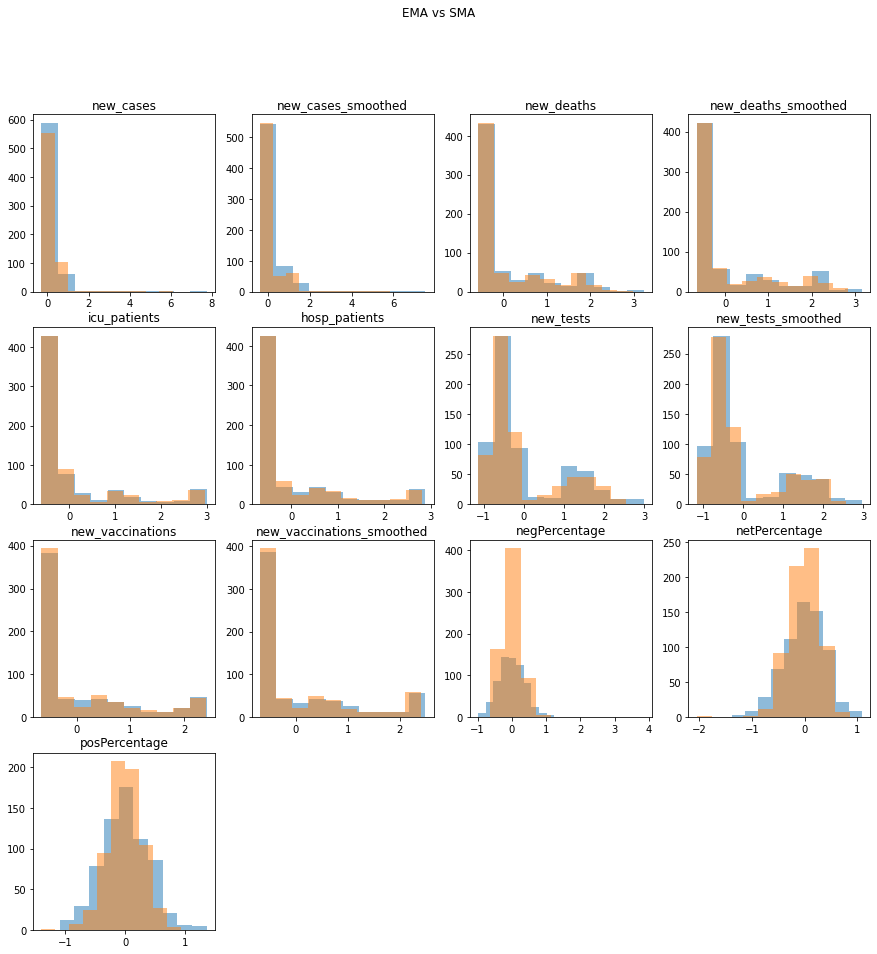

In [215]:
fig = plt.figure(figsize=(15,15))
i = 0
for col in cov_sent_sma.columns:
    i += 1
    if i == 1: continue
    ax = fig.add_subplot(4, 4, i-1)
    ax.hist(cov_sent_sma[col], alpha=0.5)
    ax.hist(cov_sent_ema[col], alpha=0.5)
    ax.set_title(col)
fig.suptitle("EMA vs SMA")
plt.show()


They are very similar, but we will still try to use both to see whether we find any interesting insights with any of them.

#### Derive / delta function with the day before

In [216]:
def delta(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


In [217]:
cov_sent_delta = pd.DataFrame(cov_sent_norm["date"])
for c in cov_sent_norm.drop("date", axis=1).columns:
    cov_sent_delta[c] = delta(cov_sent_norm[c])

### 3. Correlation Matrix

In [218]:
def plot_corr(df, size=10, show_numbers=True):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    mat = ax.matshow(corr)
    if show_numbers:
        for (i, j), z in np.ndenumerate(corr):
            ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    ax.tick_params()
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    fig.colorbar(mat)
    plt.show()
    return corr


Test correlation matrix


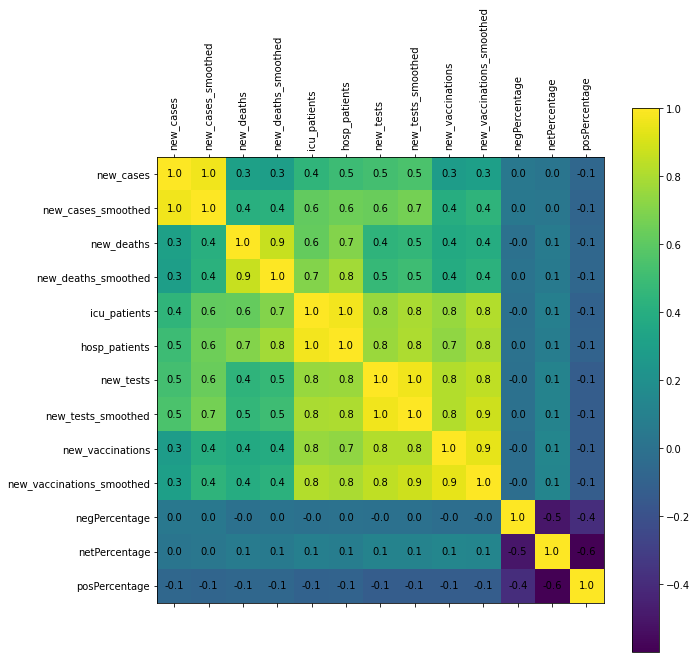

,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
new_cases,1.000000,0.966852,0.308148,0.296626,0.448257,0.495070,0.524226,0.545267,0.285399,0.306070,0.041968,0.022283,-0.062664
new_cases_smoothed,0.966852,1.000000,0.407932,0.424524,0.615788,0.647122,0.636592,0.669080,0.395646,0.443760,0.039094,0.037020,-0.075691
new_deaths,0.308148,0.407932,1.000000,0.865757,0.622832,0.701781,0.443135,0.459622,0.373616,0.389394,-0.002587,0.064612,-0.066409
new_deaths_smoothed,0.296626,0.424524,0.865757,1.000000,0.701895,0.778403,0.472498,0.505942,0.385415,0.429084,0.011283,0.051932,-0.065773
icu_patients,0.448257,0.615788,0.622832,0.701895,1.000000,0.969411,0.755172,0.796286,0.753452,0.818411,-0.000897,0.092318,-0.097483
hosp_patients,0.495070,0.647122,0.701781,0.778403,0.969411,1.000000,0.762387,0.805733,0.737567,0.798568,0.005760,0.079988,-0.090527
new_tests,0.524226,0.636592,0.443135,0.472498,0.755172,0.762387,1.000000,0.967787,0.814078,0.846006,-0.001396,0.118584,-0.124992
new_tests_smoothed,0.545267,0.669080,0.459622,0.505942,0.796286,0.805733,0.967787,1.000000,0.817432,0.876270,0.000306,0.117744,-0.125676
new_vaccinations,0.285399,0.395646,0.373616,0.385415,0.753452,0.737567,0.814078,0.817432,1.000000,0.941289,-0.020769,0.138263,-0.127977
new_vaccinations_smoothed,0.306070,0.443760,0.389394,0.429084,0.818411,0.798568,0.846006,0.876270,0.941289,1.000000,-0.017503,0.131464,-0.123767


In [219]:
plot_corr(cov_sent_norm)

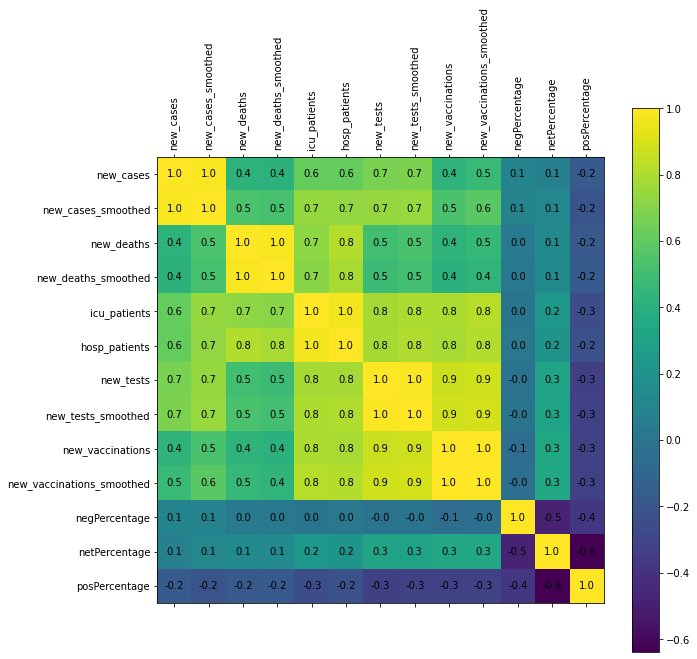

,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
new_cases,1.000000,0.980849,0.423470,0.411437,0.612853,0.611281,0.669790,0.674585,0.427381,0.474623,0.099678,0.076927,-0.168244
new_cases_smoothed,0.980849,1.000000,0.532902,0.521416,0.742884,0.734488,0.738495,0.747279,0.531468,0.578036,0.092368,0.123055,-0.210442
new_deaths,0.423470,0.532902,1.000000,0.984540,0.722982,0.810516,0.504707,0.526887,0.428880,0.451263,0.038251,0.139980,-0.180927
new_deaths_smoothed,0.411437,0.521416,0.984540,1.000000,0.708161,0.788026,0.487034,0.510056,0.409180,0.432057,0.023125,0.141627,-0.169429
icu_patients,0.612853,0.742884,0.722982,0.708161,1.000000,0.972867,0.778437,0.800718,0.801599,0.823015,0.001669,0.237529,-0.251687
hosp_patients,0.611281,0.734488,0.810516,0.788026,0.972867,1.000000,0.781009,0.805462,0.786864,0.808262,0.014327,0.208013,-0.231667
new_tests,0.669790,0.738495,0.504707,0.487034,0.778437,0.781009,1.000000,0.993531,0.872018,0.878943,-0.011148,0.321457,-0.328889
new_tests_smoothed,0.674585,0.747279,0.526887,0.510056,0.800718,0.805462,0.993531,1.000000,0.881356,0.891838,-0.006414,0.310359,-0.321340
new_vaccinations,0.427381,0.531468,0.428880,0.409180,0.801599,0.786864,0.872018,0.881356,1.000000,0.995803,-0.052978,0.344725,-0.316806
new_vaccinations_smoothed,0.474623,0.578036,0.451263,0.432057,0.823015,0.808262,0.878943,0.891838,0.995803,1.000000,-0.042450,0.336116,-0.316947


In [220]:
plot_corr(cov_sent_sma)

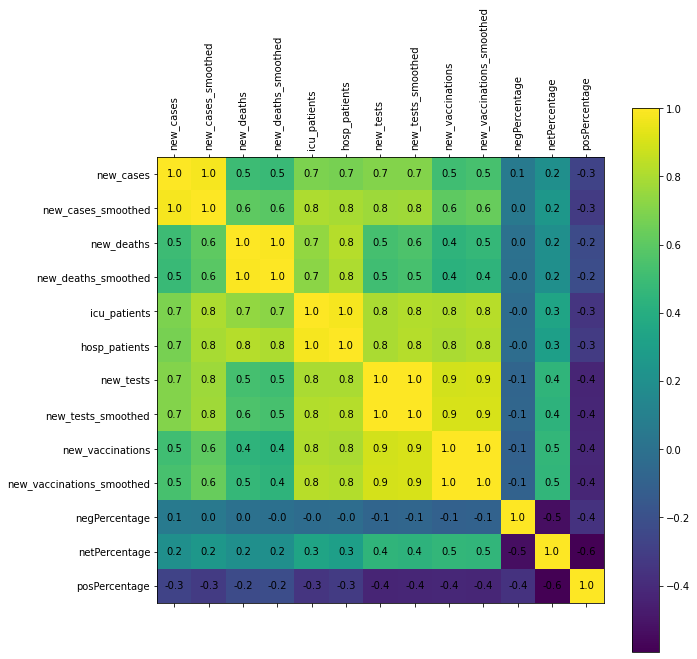

,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
new_cases,1.000000,0.979061,0.496908,0.483824,0.684633,0.671318,0.701786,0.702366,0.508079,0.534072,0.058146,0.198478,-0.275209
new_cases_smoothed,0.979061,1.000000,0.602406,0.590233,0.806664,0.788376,0.764409,0.770071,0.603772,0.631952,0.048541,0.246615,-0.319337
new_deaths,0.496908,0.602406,1.000000,0.991391,0.740675,0.823786,0.531841,0.552724,0.445694,0.466146,0.003577,0.202134,-0.227193
new_deaths_smoothed,0.483824,0.590233,0.991391,1.000000,0.724149,0.801195,0.512201,0.533927,0.423392,0.445346,-0.002789,0.199564,-0.218274
icu_patients,0.684633,0.806664,0.740675,0.724149,1.000000,0.976654,0.796490,0.816139,0.811023,0.830087,-0.030870,0.338510,-0.345308
hosp_patients,0.671318,0.788376,0.823786,0.801195,0.976654,1.000000,0.799239,0.820761,0.798799,0.816601,-0.021990,0.304906,-0.316578
new_tests,0.701786,0.764409,0.531841,0.512201,0.796490,0.799239,1.000000,0.996911,0.893488,0.896307,-0.071646,0.447833,-0.427435
new_tests_smoothed,0.702366,0.770071,0.552724,0.533927,0.816139,0.820761,0.996911,1.000000,0.900954,0.906043,-0.067552,0.438376,-0.420871
new_vaccinations,0.508079,0.603772,0.445694,0.423392,0.811023,0.798799,0.893488,0.900954,1.000000,0.997083,-0.097364,0.462180,-0.418782
new_vaccinations_smoothed,0.534072,0.631952,0.466146,0.445346,0.830087,0.816601,0.896307,0.906043,0.997083,1.000000,-0.089913,0.457755,-0.420992


In [221]:
plot_corr(cov_sent_ema)

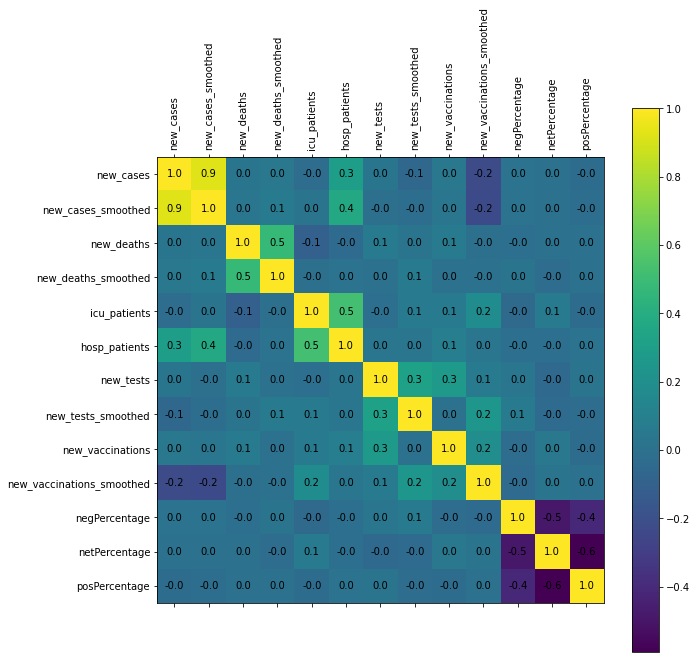

,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
new_cases,1.000000,0.922170,0.027202,0.044035,-0.020777,0.303748,0.024561,-0.058133,0.047908,-0.218213,0.017867,0.010608,-0.027626
new_cases_smoothed,0.922170,1.000000,0.031872,0.055902,0.022896,0.367555,-0.001020,-0.014252,0.030680,-0.233539,0.012952,0.001214,-0.013259
new_deaths,0.027202,0.031872,1.000000,0.475501,-0.100871,-0.036918,0.064687,0.020026,0.073110,-0.004466,-0.010075,0.004661,0.004458
new_deaths_smoothed,0.044035,0.055902,0.475501,1.000000,-0.000735,0.015131,0.007653,0.055484,0.002908,-0.000063,0.018846,-0.023052,0.006638
icu_patients,-0.020777,0.022896,-0.100871,-0.000735,1.000000,0.524609,-0.010376,0.064974,0.063954,0.184113,-0.043742,0.065889,-0.028345
hosp_patients,0.303748,0.367555,-0.036918,0.015131,0.524609,1.000000,0.031708,0.034256,0.086715,0.032531,-0.007583,-0.008471,0.015871
new_tests,0.024561,-0.001020,0.064687,0.007653,-0.010376,0.031708,1.000000,0.320971,0.261926,0.061867,0.031707,-0.047558,0.020336
new_tests_smoothed,-0.058133,-0.014252,0.020026,0.055484,0.064974,0.034256,0.320971,1.000000,0.001324,0.247409,0.061832,-0.034984,-0.020693
new_vaccinations,0.047908,0.030680,0.073110,0.002908,0.063954,0.086715,0.261926,0.001324,1.000000,0.186933,-0.023783,0.047490,-0.027600
new_vaccinations_smoothed,-0.218213,-0.233539,-0.004466,-0.000063,0.184113,0.032531,0.061867,0.247409,0.186933,1.000000,-0.032456,0.019046,0.010149


In [222]:
plot_corr(cov_sent_delta)

### 4. Pair-plotting

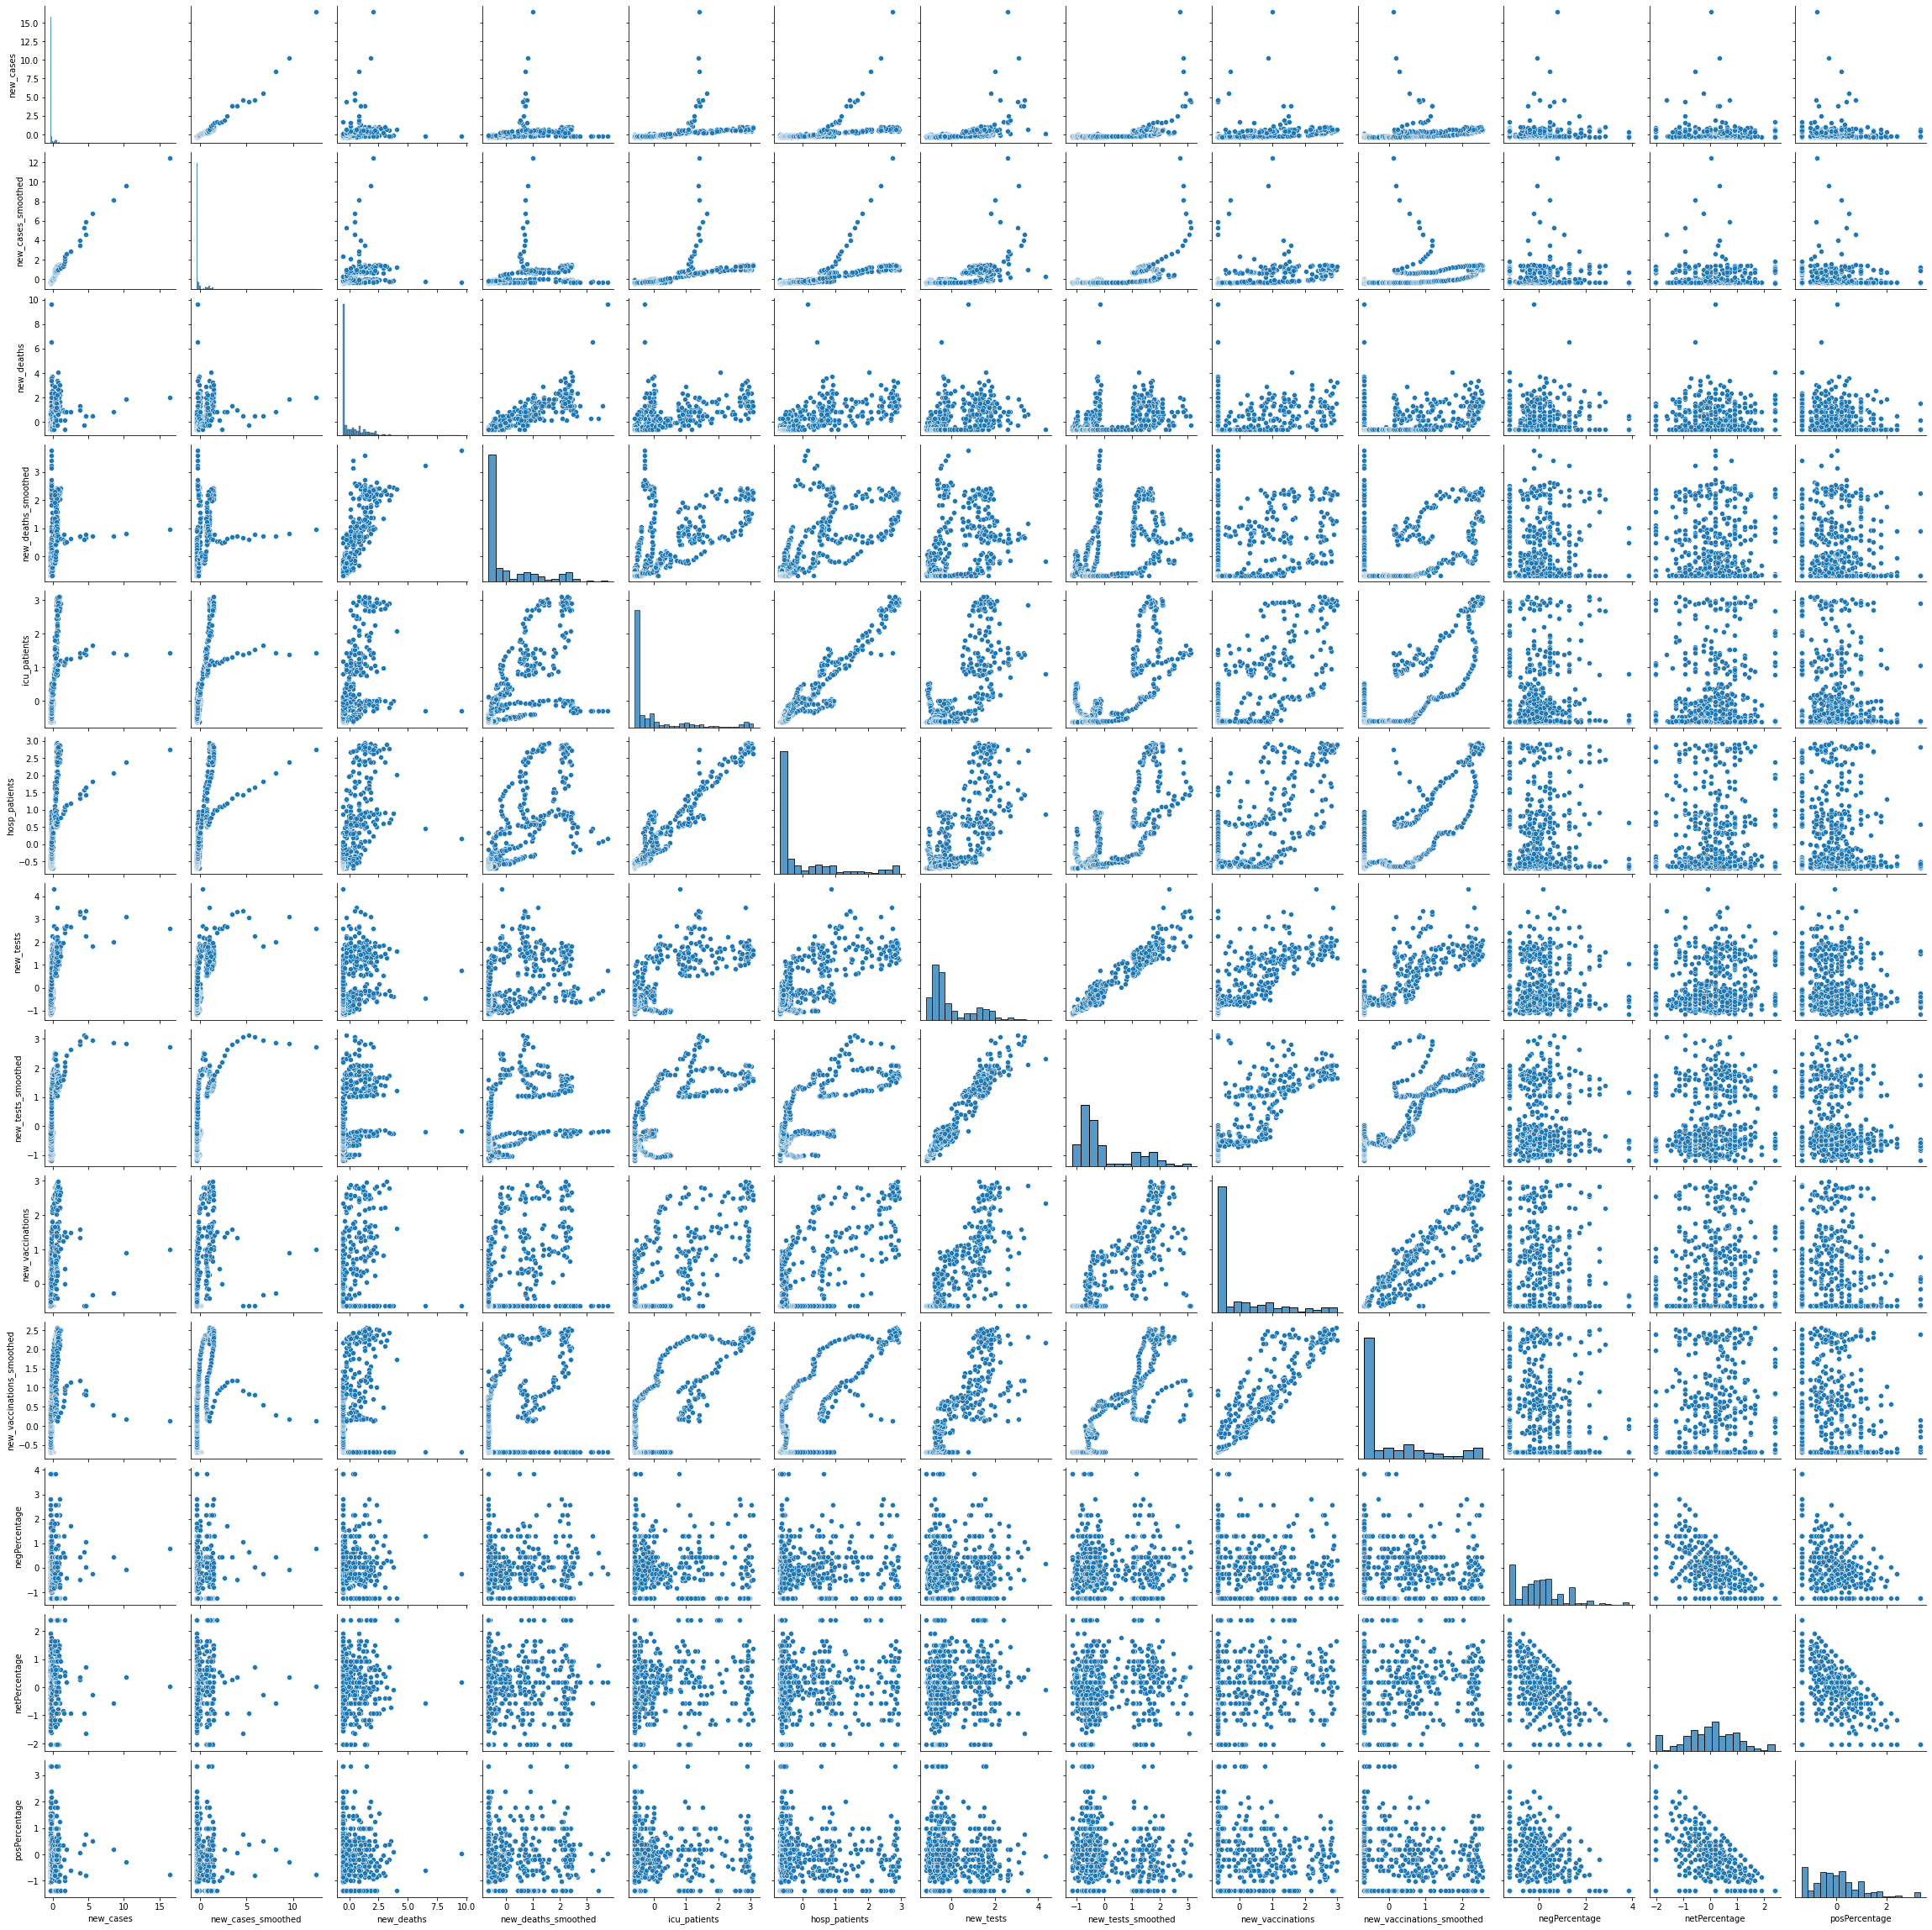

In [223]:
sns.pairplot(cov_sent_norm)
plt.show()

### 5. Mixing Moving Average data with Given data

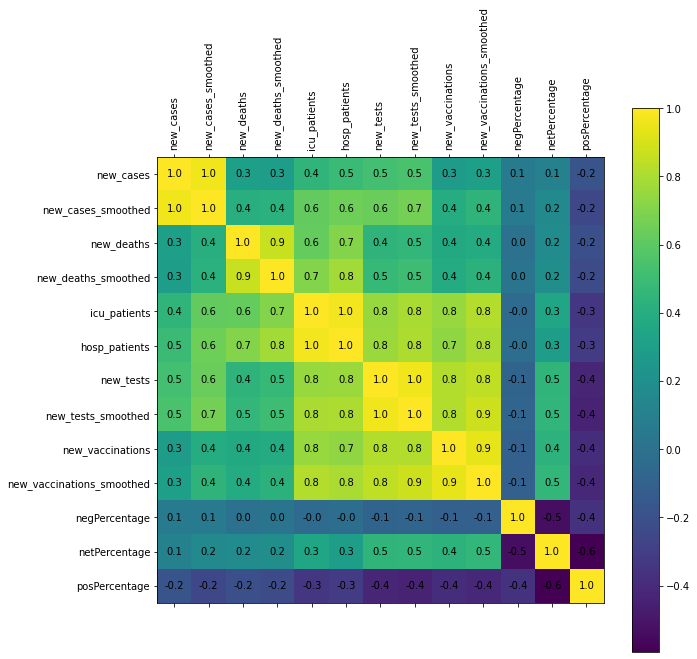

,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
new_cases,1.000000,0.966852,0.308148,0.296626,0.448257,0.495070,0.524226,0.545267,0.285399,0.306070,0.066501,0.107403,-0.182352
new_cases_smoothed,0.966852,1.000000,0.407932,0.424524,0.615788,0.647122,0.636592,0.669080,0.395646,0.443760,0.063298,0.168762,-0.247225
new_deaths,0.308148,0.407932,1.000000,0.865757,0.622832,0.701781,0.443135,0.459622,0.373616,0.389394,0.007641,0.178015,-0.204369
new_deaths_smoothed,0.296626,0.424524,0.865757,1.000000,0.701895,0.778403,0.472498,0.505942,0.385415,0.429084,0.017139,0.192153,-0.229081
icu_patients,0.448257,0.615788,0.622832,0.701895,1.000000,0.969411,0.755172,0.796286,0.753452,0.818411,-0.039164,0.341123,-0.340288
hosp_patients,0.495070,0.647122,0.701781,0.778403,0.969411,1.000000,0.762387,0.805733,0.737567,0.798568,-0.017101,0.302079,-0.318113
new_tests,0.524226,0.636592,0.443135,0.472498,0.755172,0.762387,1.000000,0.967787,0.814078,0.846006,-0.080086,0.452001,-0.423997
new_tests_smoothed,0.545267,0.669080,0.459622,0.505942,0.796286,0.805733,0.967787,1.000000,0.817432,0.876270,-0.074199,0.454659,-0.432556
new_vaccinations,0.285399,0.395646,0.373616,0.385415,0.753452,0.737567,0.814078,0.817432,1.000000,0.941289,-0.104764,0.437353,-0.384236
new_vaccinations_smoothed,0.306070,0.443760,0.389394,0.429084,0.818411,0.798568,0.846006,0.876270,0.941289,1.000000,-0.102897,0.461250,-0.412473


In [224]:
sent_cols = sentiments.columns.drop("day")
cov_cols  = covid.columns.drop("iso_code")

# Sent: norm; Covid: EMA
mix1_ema_norm = pd.merge(cov_sent_norm[cov_cols], cov_sent_ema[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix1_ema_norm)

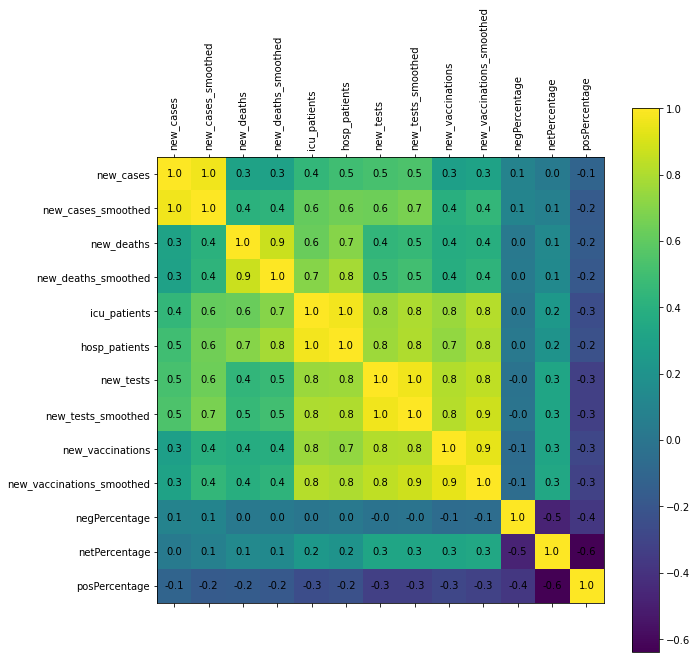

,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
new_cases,1.000000,0.966852,0.308148,0.296626,0.448257,0.495070,0.524226,0.545267,0.285399,0.306070,0.094629,0.028633,-0.112950
new_cases_smoothed,0.966852,1.000000,0.407932,0.424524,0.615788,0.647122,0.636592,0.669080,0.395646,0.443760,0.099877,0.076637,-0.168112
new_deaths,0.308148,0.407932,1.000000,0.865757,0.622832,0.701781,0.443135,0.459622,0.373616,0.389394,0.023996,0.133433,-0.161560
new_deaths_smoothed,0.296626,0.424524,0.865757,1.000000,0.701895,0.778403,0.472498,0.505942,0.385415,0.429084,0.038970,0.139574,-0.181129
icu_patients,0.448257,0.615788,0.622832,0.701895,1.000000,0.969411,0.755172,0.796286,0.753452,0.818411,0.002137,0.236677,-0.251199
hosp_patients,0.495070,0.647122,0.701781,0.778403,0.969411,1.000000,0.762387,0.805733,0.737567,0.798568,0.021509,0.203020,-0.232690
new_tests,0.524226,0.636592,0.443135,0.472498,0.755172,0.762387,1.000000,0.967787,0.814078,0.846006,-0.015897,0.323055,-0.326419
new_tests_smoothed,0.545267,0.669080,0.459622,0.505942,0.796286,0.805733,0.967787,1.000000,0.817432,0.876270,-0.010514,0.321918,-0.329929
new_vaccinations,0.285399,0.395646,0.373616,0.385415,0.753452,0.737567,0.814078,0.817432,1.000000,0.941289,-0.061523,0.323802,-0.287288
new_vaccinations_smoothed,0.306070,0.443760,0.389394,0.429084,0.818411,0.798568,0.846006,0.876270,0.941289,1.000000,-0.050728,0.342188,-0.316102


In [225]:
# Sent: norm; Covid: SMA
mix2_norm_sma = pd.merge(cov_sent_norm[cov_cols], cov_sent_sma[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix2_norm_sma)

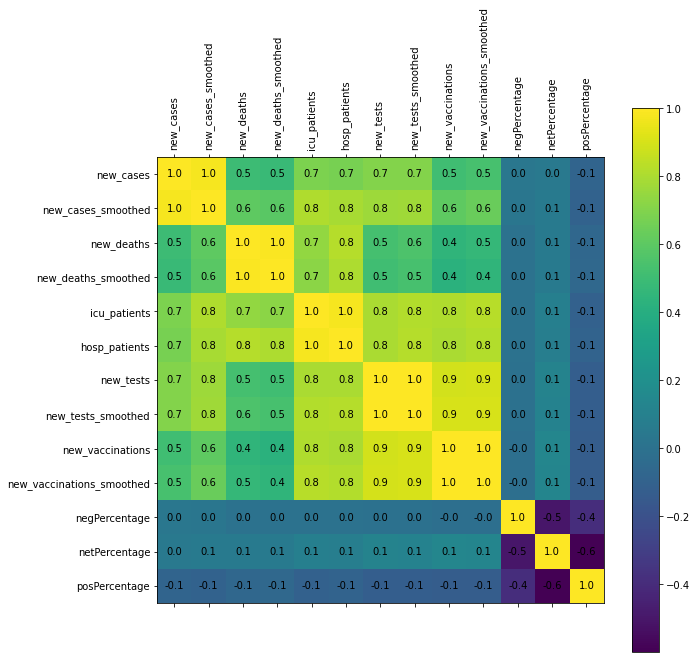

,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
new_cases,1.000000,0.979061,0.496908,0.483824,0.684633,0.671318,0.701786,0.702366,0.508079,0.534072,0.036598,0.046682,-0.083666
new_cases_smoothed,0.979061,1.000000,0.602406,0.590233,0.806664,0.788376,0.764409,0.770071,0.603772,0.631952,0.031299,0.061063,-0.094066
new_deaths,0.496908,0.602406,1.000000,0.991391,0.740675,0.823786,0.531841,0.552724,0.445694,0.466146,0.006346,0.055361,-0.064844
new_deaths_smoothed,0.483824,0.590233,0.991391,1.000000,0.724149,0.801195,0.512201,0.533927,0.423392,0.445346,0.001489,0.055335,-0.060310
icu_patients,0.684633,0.806664,0.740675,0.724149,1.000000,0.976654,0.796490,0.816139,0.811023,0.830087,0.002554,0.092809,-0.101207
hosp_patients,0.671318,0.788376,0.823786,0.801195,0.976654,1.000000,0.799239,0.820761,0.798799,0.816601,0.003077,0.083227,-0.091488
new_tests,0.701786,0.764409,0.531841,0.512201,0.796490,0.799239,1.000000,0.996911,0.893488,0.896307,0.000831,0.115019,-0.123261
new_tests_smoothed,0.702366,0.770071,0.552724,0.533927,0.816139,0.820761,0.996911,1.000000,0.900954,0.906043,0.000983,0.111998,-0.120186
new_vaccinations,0.508079,0.603772,0.445694,0.423392,0.811023,0.798799,0.893488,0.900954,1.000000,0.997083,-0.017361,0.133868,-0.126457
new_vaccinations_smoothed,0.534072,0.631952,0.466146,0.445346,0.830087,0.816601,0.896307,0.906043,0.997083,1.000000,-0.014680,0.129754,-0.124564


In [226]:
# Sent: EMA; Covid: norm
mix3_ema_norm = pd.merge(cov_sent_ema[cov_cols], cov_sent_norm[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix3_ema_norm)

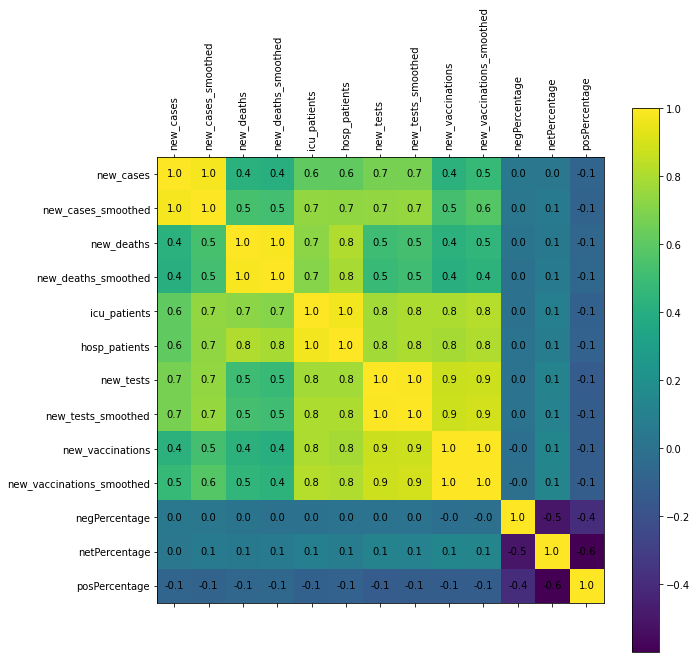

,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
new_cases,1.000000,0.980849,0.423470,0.411437,0.612853,0.611281,0.669790,0.674585,0.427381,0.474623,0.042597,0.036771,-0.078167
new_cases_smoothed,0.980849,1.000000,0.532902,0.521416,0.742884,0.734488,0.738495,0.747279,0.531468,0.578036,0.038631,0.052432,-0.091196
new_deaths,0.423470,0.532902,1.000000,0.984540,0.722982,0.810516,0.504707,0.526887,0.428880,0.451263,0.015400,0.051050,-0.068435
new_deaths_smoothed,0.411437,0.521416,0.984540,1.000000,0.708161,0.788026,0.487034,0.510056,0.409180,0.432057,0.002461,0.057342,-0.063272
icu_patients,0.612853,0.742884,0.722982,0.708161,1.000000,0.972867,0.778437,0.800718,0.801599,0.823015,0.005538,0.092379,-0.103374
hosp_patients,0.611281,0.734488,0.810516,0.788026,0.972867,1.000000,0.781009,0.805462,0.786864,0.808262,0.008939,0.080899,-0.094276
new_tests,0.669790,0.738495,0.504707,0.487034,0.778437,0.781009,1.000000,0.993531,0.872018,0.878943,0.007878,0.116716,-0.131416
new_tests_smoothed,0.674585,0.747279,0.526887,0.510056,0.800718,0.805462,0.993531,1.000000,0.881356,0.891838,0.008251,0.112804,-0.127594
new_vaccinations,0.427381,0.531468,0.428880,0.409180,0.801599,0.786864,0.872018,0.881356,1.000000,0.995803,-0.015106,0.132800,-0.127466
new_vaccinations_smoothed,0.474623,0.578036,0.451263,0.432057,0.823015,0.808262,0.878943,0.891838,0.995803,1.000000,-0.010644,0.128297,-0.126763


In [227]:
# Sent: SMA; Covid: norm
mix4_sma_norm = pd.merge(cov_sent_sma[cov_cols], cov_sent_norm[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix4_sma_norm)

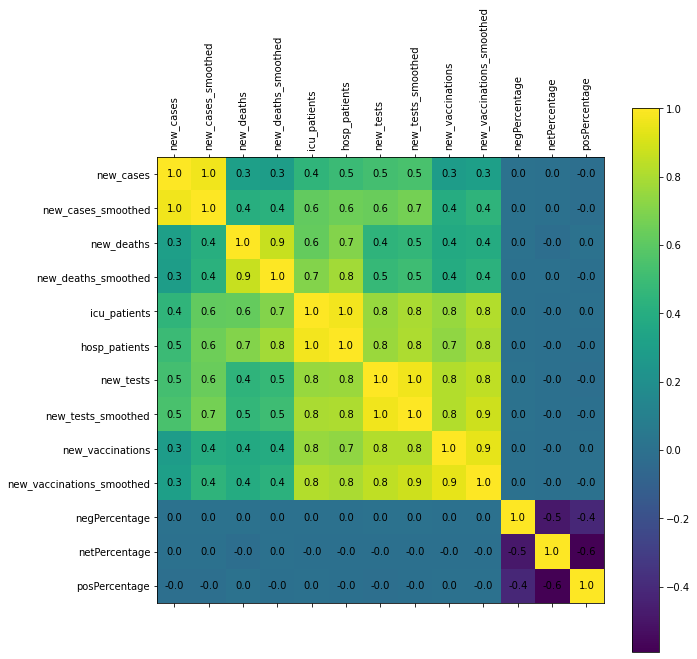

,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
new_cases,1.000000,0.966852,0.308148,0.296626,0.448257,0.495070,0.524226,0.545267,0.285399,0.306070,0.008558,0.001051,-0.009021
new_cases_smoothed,0.966852,1.000000,0.407932,0.424524,0.615788,0.647122,0.636592,0.669080,0.395646,0.443760,0.008270,0.000798,-0.008490
new_deaths,0.308148,0.407932,1.000000,0.865757,0.622832,0.701781,0.443135,0.459622,0.373616,0.389394,0.011768,-0.016027,0.005850
new_deaths_smoothed,0.296626,0.424524,0.865757,1.000000,0.701895,0.778403,0.472498,0.505942,0.385415,0.429084,0.000186,0.000332,-0.000519
icu_patients,0.448257,0.615788,0.622832,0.701895,1.000000,0.969411,0.755172,0.796286,0.753452,0.818411,0.004125,-0.003853,0.000207
hosp_patients,0.495070,0.647122,0.701781,0.778403,0.969411,1.000000,0.762387,0.805733,0.737567,0.798568,0.004691,-0.000921,-0.003381
new_tests,0.524226,0.636592,0.443135,0.472498,0.755172,0.762387,1.000000,0.967787,0.814078,0.846006,0.011534,-0.001523,-0.009087
new_tests_smoothed,0.545267,0.669080,0.459622,0.505942,0.796286,0.805733,0.967787,1.000000,0.817432,0.876270,0.005938,-0.003103,-0.002255
new_vaccinations,0.285399,0.395646,0.373616,0.385415,0.753452,0.737567,0.814078,0.817432,1.000000,0.941289,0.003769,-0.005570,0.002330
new_vaccinations_smoothed,0.306070,0.443760,0.389394,0.429084,0.818411,0.798568,0.846006,0.876270,0.941289,1.000000,0.003768,-0.002995,-0.000359


In [228]:
# Sent: norm; Covid: delta
mix5_norm_delta = pd.merge(cov_sent_norm[cov_cols], cov_sent_delta[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix5_norm_delta)

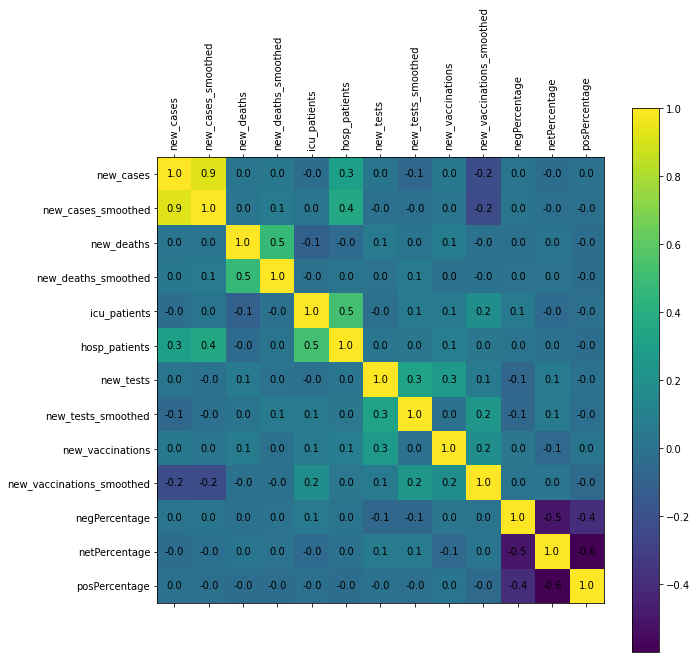

,new_cases,new_cases_smoothed,new_deaths,new_deaths_smoothed,icu_patients,hosp_patients,new_tests,new_tests_smoothed,new_vaccinations,new_vaccinations_smoothed,negPercentage,netPercentage,posPercentage
new_cases,1.000000,0.922170,0.027202,0.044035,-0.020777,0.303748,0.024561,-0.058133,0.047908,-0.218213,0.015718,-0.019330,0.006013
new_cases_smoothed,0.922170,1.000000,0.031872,0.055902,0.022896,0.367555,-0.001020,-0.014252,0.030680,-0.233539,0.026191,-0.012614,-0.010857
new_deaths,0.027202,0.031872,1.000000,0.475501,-0.100871,-0.036918,0.064687,0.020026,0.073110,-0.004466,0.000014,0.020291,-0.021631
new_deaths_smoothed,0.044035,0.055902,0.475501,1.000000,-0.000735,0.015131,0.007653,0.055484,0.002908,-0.000063,0.009619,0.013070,-0.022849
icu_patients,-0.020777,0.022896,-0.100871,-0.000735,1.000000,0.524609,-0.010376,0.064974,0.063954,0.184113,0.052946,-0.039607,-0.006919
hosp_patients,0.303748,0.367555,-0.036918,0.015131,0.524609,1.000000,0.031708,0.034256,0.086715,0.032531,0.019606,0.001034,-0.019289
new_tests,0.024561,-0.001020,0.064687,0.007653,-0.010376,0.031708,1.000000,0.320971,0.261926,0.061867,-0.067614,0.061163,-0.002441
new_tests_smoothed,-0.058133,-0.014252,0.020026,0.055484,0.064974,0.034256,0.320971,1.000000,0.001324,0.247409,-0.055503,0.063524,-0.016191
new_vaccinations,0.047908,0.030680,0.073110,0.002908,0.063954,0.086715,0.261926,0.001324,1.000000,0.186933,0.032630,-0.050589,0.023629
new_vaccinations_smoothed,-0.218213,-0.233539,-0.004466,-0.000063,0.184113,0.032531,0.061867,0.247409,0.186933,1.000000,0.014009,0.029140,-0.044041


In [229]:
# Sent: delta; Covid: norm
mix6_delta_norm = pd.merge(cov_sent_delta[cov_cols], cov_sent_norm[["date", *sent_cols]], how="inner", left_on="date", right_on="date")
plot_corr(mix6_delta_norm)

### 6. PCA: apply PCA on Covid data and see whether each sentiment can be distinguished

Both date and sentiment data should be dropped, as the first isn't helpful in PCA and the second features are the ones we are trying to distinguish.

We then choose the X values we are going to apply PCA on:

In [230]:
X = cov_sent_norm.drop(["date", *sent_cols], axis=1).fillna(0).values

Lets first check how many singular values we should select to obtain a 95% covariance explanation

In [231]:
U,S,V = svd(X, full_matrices=False)
rho = (S*S) / (S*S).sum()

threshold = 0.95

Plot variance threshold

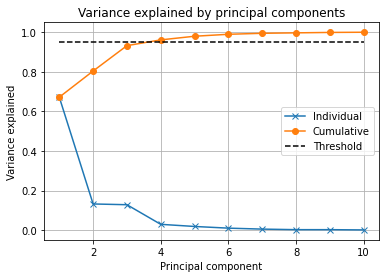

In [232]:
plt.figure()
plt.plot(range(1, len(rho)+1),rho, 'x-')
plt.plot(range(1, len(rho)+1),np.cumsum(rho), 'o-')
plt.plot([1,len(rho)],[threshold, threshold], 'k--')
plt.title('Variance explained by principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Individual', 'Cumulative', 'Threshold'])
plt.grid()
plt.show()

Choose number of components and apply PCA:

In [233]:
n_components = sum(np.cumsum(rho) < threshold) + 1  # How many number of components should be chosen?

# Apply PCA
pca = PCA(n_components=n_components)  # Chosen by previous plot
cov_sent_r = pca.fit_transform(X)

pca.explained_variance_ratio_

array([0.67187725, 0.13209319, 0.12826826, 0.02916845])

Create "column" to label each row for its maximum value between positive, negative or net sentiment

In [234]:
y = pd.Series(cov_sent_norm[[*sent_cols]].idxmax(axis=1))

Plot first two PCs

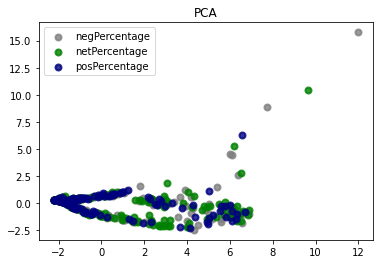

In [235]:
target_names = y.unique()
colors = ["gray", "green", "navy"]
lw = 2

for color, target_name in zip(colors, target_names):
    plt.scatter(
        cov_sent_r[y == target_name, 0], cov_sent_r[y == target_name, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA")
plt.show()